# Смена директории

In [1]:
%cd ..

/Users/macbook/Desktop/Project/Year_project


# Импорт библиотек

In [ ]:
import logging
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import optuna
from catboost import CatBoostClassifier, Pool


from utils.plot_utils import time_ranges_plot
from utils.eda_utils import get_vars_statistics
from utils.style_utils import print_multiple_html, k_formatter
from utils.psi import StabilityIndexCalculator

In [259]:
logging.getLogger().setLevel(logging.WARNING)
warnings.filterwarnings('ignore')
sns.set_palette('bright')


pd.options.display.float_format = "{:.2f}".format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [260]:
%load_ext autoreload
%autoreload 2
%aimport utils.plot_utils
%aimport utils.eda_utils
%aimport utils.style_utils
%aimport utils.psi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Загрузка данных

In [261]:
data = pd.read_parquet('./data/processed/data.pqt')

In [264]:
TRAIN_MASK = (data['sample_type'] == 'TRAIN')
TEST_MASK = (data['sample_type'] == 'TEST')
OOT_MASK = (data['sample_type'] == 'OOT')

## Работа с валидными фичами, полученными в результате data_preparation

In [263]:
path = r'./docs/valid_features.xlsx'
valid_features_data = pd.read_excel(path, index_col=False)
VALID_FEATURES = list(valid_features_data['attribute'].values)

## Приведение колонок типа данных «object» к формату «category» 

In [270]:
OBJECT_FEATURES =  list(set(VALID_FEATURES) & set(data.select_dtypes(include=["object"]).columns))    

for feature in OBJECT_FEATURES:
    data[feature] = data[feature].astype(str).astype("category")

CAT_FEATURES =  list(set(VALID_FEATURES) & set(data.select_dtypes(include=["category"]).columns))

## Создание специального объекта Pool для Catboost

In [271]:
def get_pool_for_catboost(data, target, subset_mask, features, cat_features):

    pool = Pool(
        data=data[subset_mask][features],
        label=data[subset_mask][target],
        feature_names=list[any](features), 
        cat_features=list[any](cat_features)

    )

    return pool

In [272]:
train_pool = get_pool_for_catboost(data, 'target', TRAIN_MASK, VALID_FEATURES, CAT_FEATURES)
test_pool = get_pool_for_catboost(data, 'target', TEST_MASK, VALID_FEATURES, CAT_FEATURES)
oot_pool = get_pool_for_catboost(data, 'target', OOT_MASK, VALID_FEATURES, CAT_FEATURES)

## Обучение первой модели

In [ ]:
## параметры модели
params = {'iterations':100,
        'loss_function':'Logloss',
        'eval_metric':'AUC',
        'early_stopping_rounds': 200,
        'verbose': 0,
        'random_seed': 42
         }

In [274]:
%%time

## обучение модели
base_catboost = CatBoostClassifier(**params, cat_features=CAT_FEATURES)
base_catboost.fit(train_pool,
          eval_set=test_pool, 
          use_best_model=True, 
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 1min 53s, sys: 2.98 s, total: 1min 56s
Wall time: 13.3 s


### Подсчет значения ROC AUC для базовой модели

In [275]:
roc_auc_train = roc_auc_score(data[TRAIN_MASK]['target'], base_catboost.predict_proba(train_pool)[:, 1])
roc_auc_test = roc_auc_score(data[TEST_MASK]['target'], base_catboost.predict_proba(test_pool)[:, 1])

print("ROC AUC на Train: %.4f" % roc_auc_train)
print("ROC AUC на Test: %.4f" % roc_auc_test)


ROC AUC на Train: 0.9178
ROC AUC на Test: 0.9094


### Изменение качества модели при изменении параметра iterations (количество деревьев)

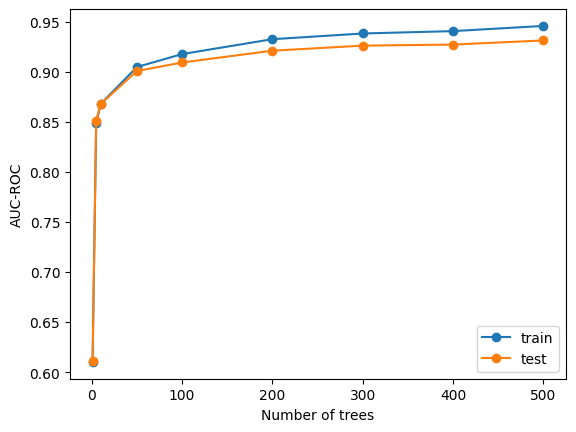

In [233]:
## параметры модели
params = {
        'loss_function':'Logloss',
        'eval_metric':'AUC',
        'early_stopping_rounds': 200,
        'verbose': 0,
        'random_seed': 42
         }

n_trees = [1, 5, 10, 50, 100, 200, 300, 400, 500]
quals_train = []
quals_test = []
for n in n_trees:
    catboost = CatBoostClassifier(
               **params,
               iterations=n, 
               )
    catboost.fit(train_pool,
          eval_set=test_pool, 
          use_best_model=True, 
          plot=False
         );
    q_train = roc_auc_score(data[TRAIN_MASK]['target'], catboost.predict_proba(train_pool)[:, 1])
    q_test = roc_auc_score(data[TEST_MASK]['target'], catboost.predict_proba(test_pool)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.plot(n_trees, quals_train, marker='o', label='train')
plt.plot(n_trees, quals_test, marker='o', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()
plt.show();

###  Подбор гиперпараметров с Optuna


In [251]:
def optuna_optimization(trial):
    params = {
        'loss_function':'Logloss',
        'eval_metric':'AUC',
        'verbose': 0,
        'random_seed': 42,
        'iterations':trial.suggest_int("iterations", 100, 500),
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "used_ram_limit": "6gb",
    }



    catboost = CatBoostClassifier(**params)
    catboost.fit(train_pool,
          eval_set=test_pool, 
          plot=False
          )
    
    roc_auc = roc_auc_score(data[TEST_MASK]['target'], catboost.predict_proba(test_pool)[:, 1])
    return roc_auc


In [254]:
study = optuna.create_study(direction='maximize')
study.optimize(optuna_optimization, n_trials=10, show_progress_bar=False);

[I 2025-12-01 22:08:07,316] A new study created in memory with name: no-name-98ea72a6-c069-4ab5-b30d-3ef5c85d5b7d
[I 2025-12-01 22:08:15,003] Trial 0 finished with value: 0.8421607286305418 and parameters: {'iterations': 166, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.04889214336250432, 'depth': 2, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 0.8421607286305418.
[I 2025-12-01 22:09:15,357] Trial 1 finished with value: 0.9034867314641348 and parameters: {'iterations': 319, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.059700030187847836, 'depth': 10, 'boosting_type': 'Ordered'}. Best is trial 1 with value: 0.9034867314641348.
[I 2025-12-01 22:10:21,207] Trial 2 finished with value: 0.9342127804815311 and parameters: {'iterations': 254, 'objective': 'Logloss', 'colsample_bylevel': 0.05291741756577173, 'depth': 11, 'boosting_type': 'Ordered'}. Best is trial 2 with value: 0.9342127804815311.
[I 2025-12-01 22:10:40,795] Trial 3 finished with value: 0.8742485518768

## Результат побдора гиперпараметров с Optuna

In [278]:
print('Best hyperparameters:', study.best_params)
print('Best ROC-AUC score on Test: %.4f' % study.best_value)

Best hyperparameters: {'iterations': 307, 'objective': 'Logloss', 'colsample_bylevel': 0.07834170184663647, 'depth': 10, 'boosting_type': 'Ordered'}
Best ROC-AUC score on Test: 0.9357
